# Part I: Assembling a Dataset & Extracting the Features

## Audio Data

The first thing we need in order to create a model for cough detection and monitoring, is the data. This data comes in the form of audio files.

Two types of audio were sought out in order to form our dataset: 
   1. The first is obviously samples of people coughing. No further label is necessary at this point, however it is useful to include examples of all sexes and ages. 
   2. The second is any type of sound that is not a cough. As the intended implementation of this model is as an overnight monitoring module, sounds that have a high likelyhood of being heard in such a scenario were sought out. These include: random talking, snoring, footsteps, doors & drawers being opened and shut, street noises as recorded from indoors.

An existing snoring dataset was very helpful in assembing our own. A number of audio samples was used from:
T. H. Khan, "A deep learning model for snoring detection and vibration notification using a smart wearable gadget," Electronics, vol. 8, no. 9, article. 987, ISSN 2079-9292, 2019.

All other audio has been obtained from open access sources, extracted from youtube videos, or recorded by the author.

In [1]:
# Import libraries to be used

import numpy as np
import os
from os import walk
import librosa as lb
import librosa.display as lbd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.silence import split_on_silence

The various raw audio files have been stored in two directories named "various cough sounds" and "various non-cough sounds". These files are uneven in length and contain multiple instances of the acoustic events in question. 

A first step we have to take is to split these raw audio files into segments each containing a single event (cough, or a non-cough instance). We chose to save the segments as wav files since they are much more convenient to work with than mp3s.

In [ ]:
def isolate_events(loadpath, savepath, min_silence_len, silence_thresh):
    '''Function to split raw audio into chunks corresponding to isolated events
    takes a specified loading path, a saving path, the minimum silence time length 
    in ms, and the threshold for silence in dB.'''
    
    sound_file = AudioSegment.from_mp3(loadpath)
    
    # split audio
    audio_chunks = split_on_silence(sound_file, 
                                    # must be silent for at least half a second
                                    min_silence_len=min_silence_len,
                                    # consider it silent if quieter than 
                                    silence_thresh=silence_thresh
                                   )
    # store the 
    for i, chunk in enumerate(audio_chunks):

        out_file = savepath+i+".wav"
        print("exporting", out_file)
        chunk.export(out_file, format="wav")

In [ ]:
# Make sure the directories exist to store the segmented audio:
if not os.path.exists("cough_segments"):
    os.makedirs("cough_segments")
if not os.path.exists("nocough_segments"):
    os.makedirs("nocough_segments")

So now we can use the above function to extract audio events from our raw audio files. We will not automate this process further, as each raw audio file requires specific settings for the minimum silence length, and the silence threshold, that are better fine tuned manually.

In [ ]:
trained# Create cough audio events - or change the paths for the non-coughing events:
LOADPATH = "path/to/raw/audio/"
SAVEPATH = "path/to/processed/audio"
isolate_events(LOADPATH, SAVEPATH, 500, -35)

## Generate Features

So now we have a dataset full of short audio files, each corresponding to a single event (cough or no-cough). 

What is next, is to generate features we can train a model on out of this audio data. A good choice when it comes to human sounds is to use the Mel Frequency Ceptral Coefficients. We will not go into detail on what these are, but librosa has a convenient method to extract and plot these features. The resulting plots will be saved as png images.

An example of an MFCC plot is shown below:

In [28]:
def demonstrate_MFCC(filepath, duration = 1, sample_rate = 44100):
    '''Calculates MFCC for a segment of specified duration from an audio file
        , using a specified sample rate, and outputs the corresponding plot.'''
    # Load audio into numpy array
    data, sr = lb.load(filepath, sr = sample_rate)
    
    # Normalize within range 0,1
    data /= np.max(np.abs(data))
    
    # Segment audio to specified duration, zero pad if too short
    if len(data) <= sr:
        data = np.append(data, np.zeros(sr-len(data)))
    else:
        data = data[:sr]
        
    # Set up plotting environment
    fig = plt.figure(figsize = [5,3])
    ax = fig.add_subplot(111)
    #ax.axes.get_xaxis().set_visible(False)
    #ax.axes.get_yaxis().set_visible(False)
    #ax.set_frame_on(False)
    
    #Calculate and plot MFCCs
    S = lb.feature.mfcc(y=data, sr=sr)
    img = lbd.specshow(S, x_axis='time')
    
    fig.colorbar(img, ax=ax)


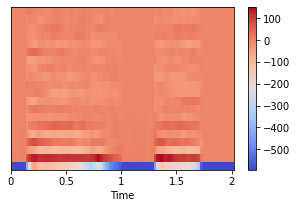

In [29]:
# Check MFCC image output for a coughing audio sample
filepath = 'path/to/coughing/audio.wav'
demonstrate_MFCC(filepath)

So this is an example of the MFCC for a cough event. Let's see what it looks like for something that is not a cough:

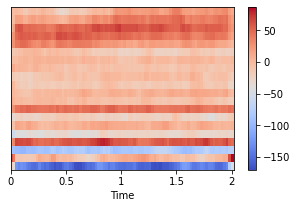

In [30]:
# Check MFCC image output for a non-coughing audio sample
filepath = 'path/to/other/audio.wav'
demonstrate_MFCC(filepath)

In a way, what we are doing is representing sound with pictures. Or the equivalent of a picture to a neural network, as all it "sees" is a multi-dimensional tensor. A great deal of the properties that define each audio sample are contained in these MFCCs. Therefore, we can rely on a model that would normally be used to classify images to perform the classification of audio events.

So, instead of pictures, we can calculate multi-dimensional arrays corresponding to the MFCCs of audio samples and use those as input for a Convolutional Neural Network to detect patterns and perform the classification task.

We can use the function below to generate a dataset of uniform audio samples in duration and sample rate, that will allow our model to be trained effectively. For this instance, we will use audio with duration of 1 second and a sampling rate of 44100 Hz.

In [ ]:
def export_sample_wavs(dirpath_from, dirpath_to, name, dur=1, sample_rate=44100):
    '''Reads audio files from a directory, segments them to a specific duration and using
        a uniform sample rate and stores them.'''
    
    # Make directory if it doesn't exist
    if not os.path.exists(dirpath_to):
        os.makedirs(dirpath_to)
    
    filepaths = []
    # Locate existing audio
    for (_,_,filenames) in walk(dirpath_from):
        filepaths.extend(filenames)
        break
    for i, filepath in enumerate(filepaths):
        # Read in audio
        data, sr = lb.load(dirpath_from + '/'+ filepath, sr = sample_rate)
        # Set length
        if len(data) >= dur * sr:
            data = data[:sr]
        else:
            data = np.append(data, np.zeros(sr-len(data)))
        # Store .wav file
        savename = dirpath_to + '/' + name + str(i) + '.wav'
        soundfile.write(savename, data, sr)

In [ ]:
dirpath_from = 'path/to/processed/audio/'
dirpath_to = 'path/to/training/dataset/'
name = 'a_fitting_filename_'

export_sample_wavs(dirpath_from, dirpath_to, name)

Now we should have a training dataset of tidied up and uniform audio samples. In the next Notebook we will load this data, extract the MFCC features, design a convolutional network and train it.